# Scorecards with SHAP

<img src= "https://miro.medium.com/v2/resize:fit:1400/1*rfJAwUkubNeDUxRKa_EuhQ.png" width=600/>

In this notebook we look into SHAP for four models: Logistic Regression, Weight of Evidence (WOE) classifier, WOE Logistic Regression, and CatBoost.

1. We show how linear SHAP values work and how they compare to WOE and show that we can derive SHAP from WOE.
2. We further show how additive SHAP values can be converted to a scorecard for linear and tree-based models.

Author: https://www.github.com/deburky

**Some resources**

* [How to calculate SHAP for a factor in a linear model?](https://stats.stackexchange.com/questions/568239/how-to-calculate-shap-for-a-factor-in-a-linear-model)
* [Why I get different expected_value when I include the training data in TreeExplainer?](https://stackoverflow.com/questions/64821829/why-i-get-different-expected-value-when-i-include-the-training-data-in-treeexpla)
* [SHAP values for linear model different from those calculated manually](https://stackoverflow.com/questions/78796974/shap-values-for-linear-model-different-from-those-calculated-manually)

## Synthetic Dataset

We will use a synthetic dataset with 1000 samples for faster computation.

In [3]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

n_features = 5

X, y = make_classification(
    n_samples=1000,
    n_features=n_features,
    n_informative=2,
    n_redundant=3,
    weights=[0.7, 0.3],
    random_state=42,
)
X, y = pd.DataFrame(X), pd.Series(y)

X.columns = [f'feature_{i}' for i in range(n_features)]
y.name = 'target'

## Logistic Regression

Here we examine the effect of SHAP values for a logistic regression model.

In a linear setup, SHAP measures the effect of centered feature values on the prediction.

This ensures we can explain the exact difference in log odds and break it down to the individual feature contributions.

In [4]:
import shap
from scipy.special import logit
from shap import maskers

model = LogisticRegression(fit_intercept=True, solver='newton-cg')
model.fit(X, y)

print(f'Intercept: {model.intercept_}')
print(f'Coefficients: {model.coef_.ravel()}')

# Note here that we use a masker due to SHAP logic
# By default, expected value will not equal to the true mean
# See the links in the notebook header
explainer = shap.LinearExplainer(
    model,
    masker=maskers.Independent(
        X, max_samples=len(X)
    ),
)
shap_values = explainer.shap_values(X)

shap_df = pd.DataFrame(
    shap_values, columns=X.columns
)

# Add extra columns
shap_df['expected_value'] = explainer.expected_value
shap_df['log_odds'] = logit(model.predict_proba(X)[:, 1]).mean()
shap_df['preds_log_odds'] = logit(model.predict_proba(X)[:, 1])

# Show 5 first rows
display(shap_df.head(5))

# SHAP = difference between prediction and expected value
display(
    shap_df.head(2).iloc[:,:5].sum(axis=1),  # sum of SHAP values
    shap_df.head(2)['preds_log_odds'] - shap_df.head(2)['expected_value'] # difference
)

Intercept: [-0.60369101]
Coefficients: [ 0.67739595  0.39165595  1.03327646  0.46681176 -0.52864631]


,feature_0,feature_1,feature_2,feature_3,feature_4,expected_value,log_odds,preds_log_odds
0,0.639799,-0.145454,0.897584,0.317109,0.162998,-1.457141,-1.457141,0.414895
1,-0.914214,0.967700,-0.032685,-0.481184,0.246405,-1.457141,-1.457141,-1.671118
2,1.706769,-0.386566,2.396852,0.845888,0.435743,-1.457141,-1.457141,3.541545
3,0.088902,-0.447438,-0.578017,0.059842,-0.246842,-1.457141,-1.457141,-2.580694
4,0.377635,0.457599,1.423706,0.167099,0.439013,-1.457141,-1.457141,1.407911


0    1.872035
1   -0.213978
dtype: float64

0    1.872035
1   -0.213978
dtype: float64

## WOE Classifier

Here we use SHAP to explain a Naive Bayes-like model.

This is an additive model without logistic regression fitted on top of the WOE values (weights for $x_i$ = 1).

We call it fake logistic regression, as it is not a real logistic regression model but rather log odds intercept and weights of 1.

In [5]:
import warnings

import numpy as np
import pandas as pd
import shap
from optbinning import BinningProcess
from shap import maskers
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")


class Classifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.intercept_ = 0  # Initialize base log odds
        self.coef_ = None
        self.is_fitted_ = False

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        self.intercept_ = np.log(np.mean(y) / (1 - np.mean(y)))
        self.coef_ = np.ones(X.shape[1])
        self.is_fitted_ = True
        return self

    def predict_proba(self, X):
        if not self.is_fitted_:
            raise NotFittedError(
                "This Classifier instance is not fitted yet. "
                "Call 'fit' with appropriate arguments before using this estimator."
            )
        # log P(Y|X) = log P(X|Y) + log P(Y)
        predicted_log_odds = -X.sum(axis=1) + self.intercept_  # Negating the sign
        prob_positive_class = self.sigmoid(predicted_log_odds)
        return np.column_stack((1 - prob_positive_class, prob_positive_class))

    def predict(self, X):
        predicted_proba = self.predict_proba(X)
        return np.argmax(predicted_proba, axis=1)


# Create a Naive Bayes-like pipeline using WOE transformation
model_woe = Pipeline(
    [
        ("binning", BinningProcess(variable_names=list(X.columns))),
        ("classifier", Classifier()),
    ]
)

# Fit the model
model_woe.fit(X, y)

# Step 1: Transform the data to get WOE features
X_woe = -model_woe[:-1].transform(X)

# Step 2: Create a fake logistic regression model
fake_logistic = LogisticRegression()
fake_logistic.coef_ = np.ones((1, X_woe.shape[1]))  # Assuming indepence
fake_logistic.intercept_ = np.array([model_woe[-1].intercept_])

# Step 3: Use SHAP's LinearExplainer
explainer = shap.LinearExplainer(
    fake_logistic,
    masker=maskers.Independent(X_woe, max_samples=len(X_woe)),
)

shap_values = explainer.shap_values(X_woe)

shap_df = pd.DataFrame(shap_values, columns=X_woe.columns)

df_comparison = pd.DataFrame(
    {
        "WOE_centered": (X_woe - X_woe.mean(axis=0)).mean(axis=1),
        "SHAP_value": shap_values.mean(axis=1),
    }
)

print(df_comparison.head(5))

   WOE_centered  SHAP_value
0      1.313900    1.313900
1     -0.626570   -0.626570
2      3.823615    3.823615
3     -0.887023   -0.887023
4      2.310127    2.310127


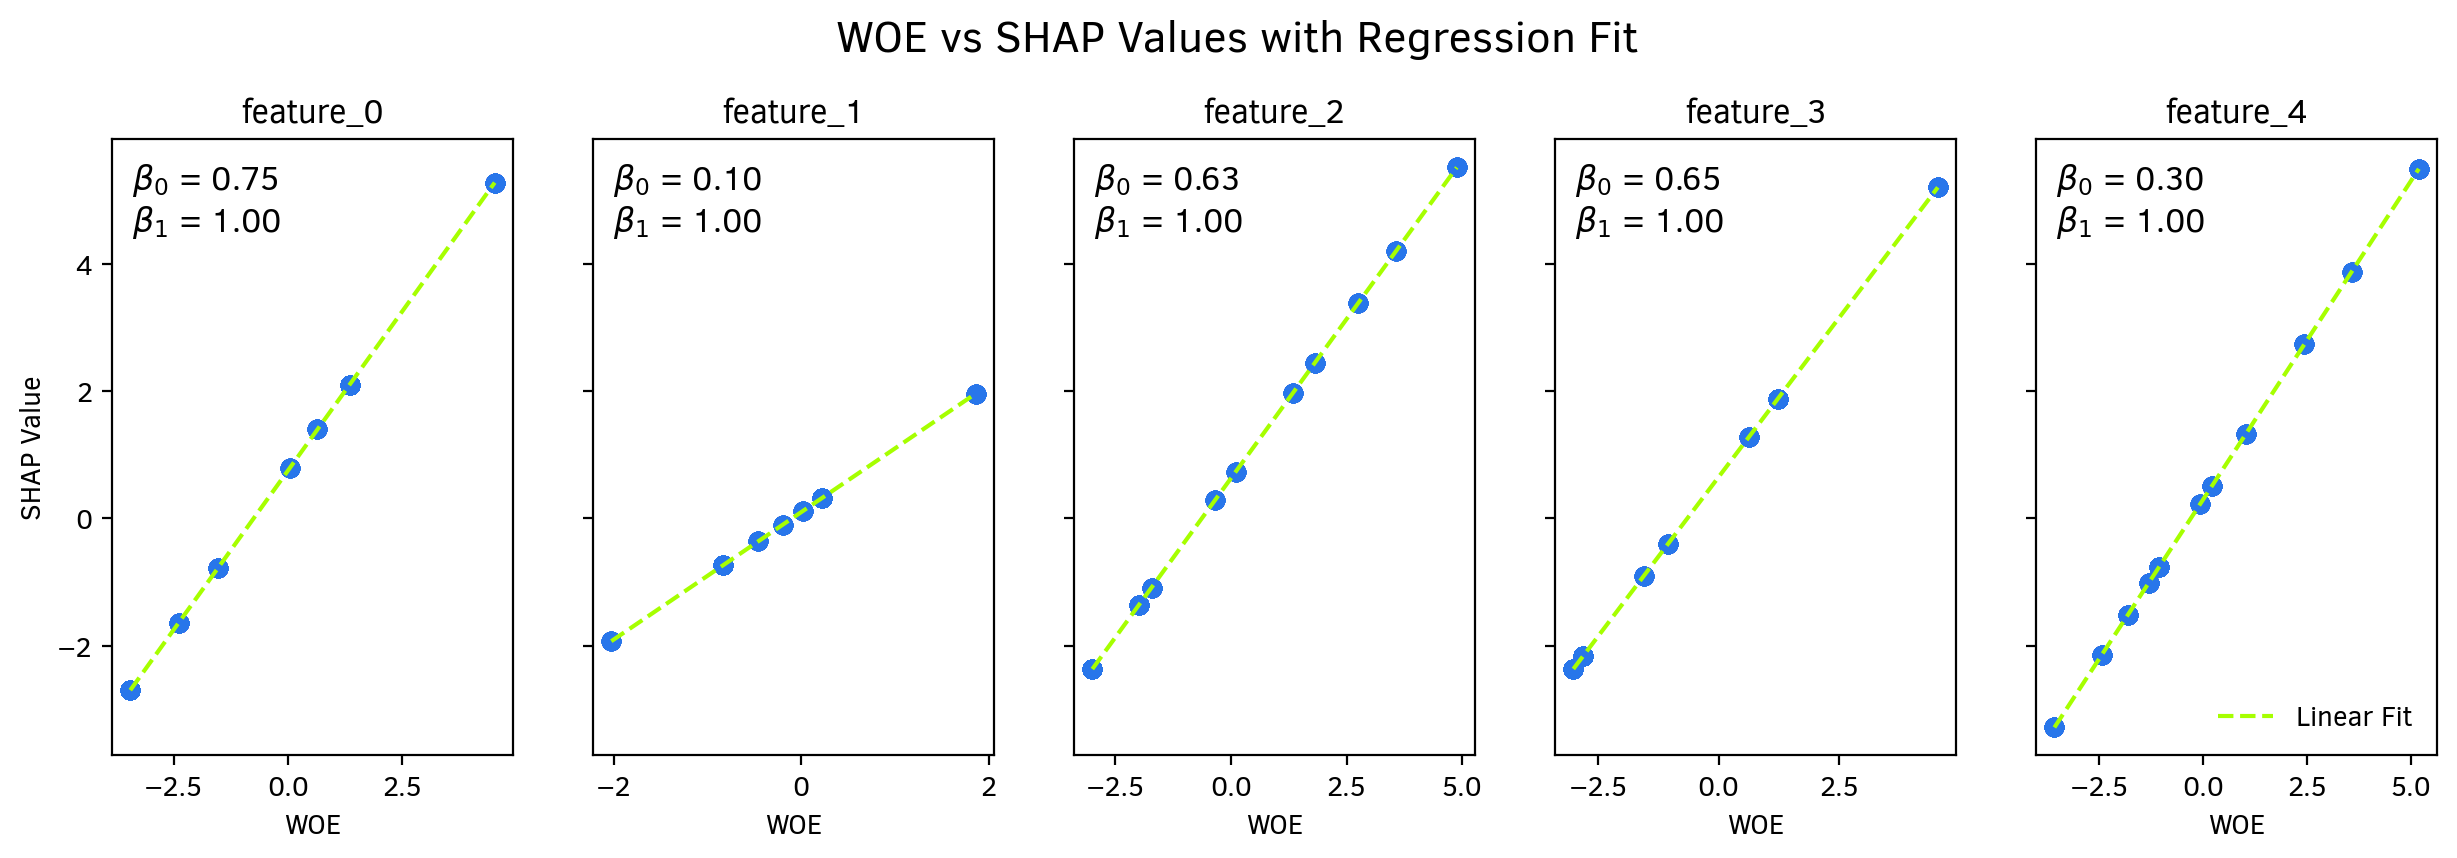

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
%config InlineBackend.figure_format = 'retina'

# Set font to "Biome"
plt.rcParams["font.family"] = "Clear Sans"

# Extracting necessary values
features = X_woe.columns

# Fit linear regression models to predict SHAP values from WOE-scaled features
lrs = []
intercepts = []
woe_scaled_corrected = {}

for i, feature in enumerate(features):
    woe_scaled_feature = X_woe[feature].values.reshape(-1, 1) * fake_logistic.coef_[0][i]
    
    lr = LinearRegression()
    lr.fit(woe_scaled_feature, shap_df[feature].values)  # Fit a simple regression model
    
    lrs.append(lr)
    intercepts.append(lr.intercept_)
    woe_scaled_corrected[feature] = woe_scaled_feature.flatten()  # Store corrected WOE values

# Scatter plot for each feature: WOE * β_i vs SHAP values with regression intercepts
fig, axes = plt.subplots(1, len(features), figsize=(15, 4), sharey=True)

for i, feature in enumerate(features):
    axes[i].scatter(woe_scaled_corrected[feature], shap_df[feature].values, alpha=0.5, color='#2876EA')
    
    # Regression line
    x_range = np.linspace(
        min(woe_scaled_corrected[feature]), max(woe_scaled_corrected[feature]), 100
    ).reshape(-1, 1)
    y_pred = lrs[i].predict(x_range)
    axes[i].plot(x_range, y_pred, color="#A6FF00", linestyle="dashed", label="Linear Fit")

    axes[i].set_title(feature)
    axes[i].set_xlabel("WOE")

    if i == 0:
        axes[i].set_ylabel("SHAP Value")

    # Add intercept value as label
    axes[i].text(
        0.05,
        0.85,
        rf"$\beta_0$ = {intercepts[i]:.2f}"
        + "\n" + rf"$\beta_1$ = {lrs[i].coef_[0]:.2f}",
        transform=axes[i].transAxes,
        fontsize=12,
    )

plt.suptitle(r"WOE vs SHAP Values with Regression Fit", fontsize=16, y=1.03)
plt.legend(loc="best", frameon=False)
plt.savefig("woe_vs_shap.png", transparent=True, dpi=300, bbox_inches="tight")
plt.show()

In this case:

* SHAP values represent the log-odds contribution of each feature in a way that is proportional to WOE.
* This relationship is perfectly linear because WOE is an additive model in the log-odds space.

We can show that:

$$SHAP_i = WOE_i - E[WOE]$$

or equivalently:

$$WOE_i = SHAP_i + E[WOE]$$

Where $E[WOE]$ is the intercept or average value of the feature $i$ (WOE-transformed).

In [7]:
e_woe = X_woe.mean(axis=0)  # WOE means or intercepts

display(
    shap_df.head(1),  # SHAP
    X_woe.head(1),  # WOE
    X_woe.head(1) - e_woe,  # SHAP = WOE - E[WOE]
    shap_df.head(1) + e_woe  # WOE = SHAP + E[WOE]
)

,feature_0,feature_1,feature_2,feature_3,feature_4
0,2.100796,0.111013,1.971278,1.878444,0.507968


,feature_0,feature_1,feature_2,feature_3,feature_4
0,1.351667,0.01267,1.343476,1.229065,0.210496


,feature_0,feature_1,feature_2,feature_3,feature_4
0,2.100796,0.111013,1.971278,1.878444,0.507968


,feature_0,feature_1,feature_2,feature_3,feature_4
0,1.351667,0.01267,1.343476,1.229065,0.210496


In [8]:
# Add extra columns
shap_df['expected_value'] = explainer.expected_value
shap_df['log_odds'] = logit(model_woe.predict_proba(X)[:, 1]).mean()
shap_df['preds_log_odds'] = logit(model_woe.predict_proba(X)[:, 1])

# Show 5 first rows
display(shap_df.head(5))

# SHAP = difference between prediction and expected value
display(
    shap_df.head(2).iloc[:,:5].sum(axis=1),  # sum of SHAP values
    shap_df.head(2)['preds_log_odds'] - shap_df.head(2)['expected_value']  # difference
)

,feature_0,feature_1,feature_2,feature_3,feature_4,expected_value,log_odds,preds_log_odds
0,2.100796,0.111013,1.971278,1.878444,0.507968,-3.245726,-3.245726,3.323774
1,-2.700460,0.319493,0.283798,-2.366473,1.330793,-3.245726,-3.245726,-6.378575
2,5.274030,-0.739082,5.511846,5.198673,3.872608,-3.245726,-3.245726,15.872349
3,-0.782967,-0.363255,-1.358000,-0.405792,-1.525102,-3.245726,-3.245726,-7.680841
4,2.100796,0.319493,3.379294,1.878444,3.872608,-3.245726,-3.245726,8.304909


0    6.569499
1   -3.132849
dtype: float64

0    6.569499
1   -3.132849
dtype: float64

## WOE Logistic Regression

This model type can be seen as an ensemble technique stacking univariate categorical logistic regression models (WOE) with a logistic regression layer. Why?

Each WOE-transformed feature can be seen as a logistic regression with one-hot encoded features. Fitting WOE-transformed features with a logistic regression is then a stacked model.

In [9]:
import pandas as pd
from optbinning import BinningProcess
from sklearn.linear_model import LogisticRegression
from scipy.special import logit

import shap
from shap import maskers

binning_process = BinningProcess(variable_names=list(X.columns))
binning_process.fit(X, y)

X_binned = binning_process.transform(X)

model = LogisticRegression(fit_intercept=True, solver='newton-cg')
model.fit(X_binned, y)

print(f'Intercept: {model.intercept_}')
print(f'Coefficients: {model.coef_.ravel()}')

explainer = shap.LinearExplainer(
    model,
    masker=maskers.Independent(X_binned, max_samples=len(X_binned)),
)

shap_values = explainer.shap_values(X_binned)

shap_df = pd.DataFrame(
    shap_values, columns=X.columns
)

shap_df['expected_value'] = explainer.expected_value
shap_df['log_odds'] = logit(model.predict_proba(X_binned)[:, 1]).mean()
shap_df['preds_log_odds'] = logit(model.predict_proba(X_binned)[:, 1])
shap_df['diff'] = shap_df['preds_log_odds'] - shap_df['expected_value']

prob_preds = model.predict_proba(X_binned)[:, 1]
log_odds_preds = logit(prob_preds)
expected_value_logit = log_odds_preds.mean()
print(expected_value_logit)

display(shap_df.head(2))

# Testing the equality of the two methods
display(shap_df.head(2).iloc[:,:5].sum(axis=1))
display(shap_df.head(2)['diff'])

Intercept: [-0.54097527]
Coefficients: [-0.78080455 -1.48794603  0.07195386 -0.06224251 -0.46361789]
-1.4053872938293566


,feature_0,feature_1,feature_2,feature_3,feature_4,expected_value,log_odds,preds_log_odds,diff
0,1.640311,0.165182,-0.141841,0.116919,0.235503,-1.405387,-1.405387,0.610686,2.016074
1,-2.108531,0.475388,-0.020420,-0.147295,0.616980,-1.405387,-1.405387,-2.589266,-1.183879


0    2.016074
1   -1.183879
dtype: float64

0    2.016074
1   -1.183879
Name: diff, dtype: float64

In [10]:
from sklearn.linear_model import LinearRegression
import numpy as np

df_woe = pd.concat([shap_df['feature_0'], -X_binned['feature_0']], axis=1)

lr = LinearRegression(fit_intercept=True)
lr.fit(X_binned['feature_0'].values.reshape(-1, 1) * model.coef_[0][0], shap_df['feature_0'].values)
print(lr.intercept_, lr.coef_)

print(f"Intercept {lr.intercept_} Coef {lr.coef_}")

df_woe['delta'] = df_woe.iloc[:, 0] - df_woe.iloc[:, 1]
b0 = lr.intercept_
b1 = lr.coef_
df_woe['woe_to_shap'] = df_woe.iloc[:, 1] * b1 + b0
display(df_woe.head(5))

print((np.ravel(X_binned.mean(axis=0)) * model.coef_)[0][0])

0.5849227305629954 [1.]
Intercept 0.5849227305629954 Coef [1.]


,feature_0,feature_0,delta,woe_to_shap
0,1.640311,1.351667,0.288643,1.936590
1,-2.108531,-3.449588,1.341057,-2.864665
2,4.117987,4.524902,-0.406915,5.109825
3,-0.611344,-1.532095,0.920751,-0.947172
4,1.640311,1.351667,0.288643,1.936590


-0.5849227305629934


In [11]:
from sklearn.linear_model import LinearRegression

lrs = []
intercepts = []
for i, feature in enumerate(X.columns):
    lr = LinearRegression()
    lr.fit(X_binned[feature].values.reshape(-1, 1) * model.coef_[0][i], shap_df[feature].values)
    lrs.append(lr)
    intercepts.append(lr.intercept_)
    print(f"Feature: {feature} | Intercept: {lr.intercept_:.2f} | Coeff: {lr.coef_[0]:.2f}")
    print(f"\nPredicted SHAP: {lr.predict(X_binned[feature].values.reshape(-1, 1) * model.coef_[0][i])[:5]}")
    print(f"Actual SHAP: {shap_df[feature].values[:5]}\n")

Feature: feature_0 | Intercept: 0.58 | Coeff: 1.00

Predicted SHAP: [ 1.64031086 -2.1085311   4.11798683 -0.6113439   1.64031086]
Actual SHAP: [ 1.64031086 -2.1085311   4.11798683 -0.6113439   1.64031086]

Feature: feature_1 | Intercept: 0.15 | Coeff: 1.00

Predicted SHAP: [ 0.16518156  0.47538795 -1.09971401 -0.54050367  0.47538795]
Actual SHAP: [ 0.16518156  0.47538795 -1.09971401 -0.54050367  0.47538795]

Feature: feature_2 | Intercept: -0.05 | Coeff: 1.00

Predicted SHAP: [-0.14184106 -0.02042033 -0.39659855  0.09771334 -0.24315326]
Actual SHAP: [-0.14184106 -0.02042033 -0.39659855  0.09771334 -0.24315326]

Feature: feature_3 | Intercept: 0.04 | Coeff: 1.00

Predicted SHAP: [ 0.11691909 -0.14729523  0.32357844 -0.02525749  0.11691909]
Actual SHAP: [ 0.11691909 -0.14729523  0.32357844 -0.02525749  0.11691909]

Feature: feature_4 | Intercept: 0.14 | Coeff: 1.00

Predicted SHAP: [ 0.23550315  0.61697954  1.79541034 -0.70706462  1.79541034]
Actual SHAP: [ 0.23550315  0.61697954  1.7954

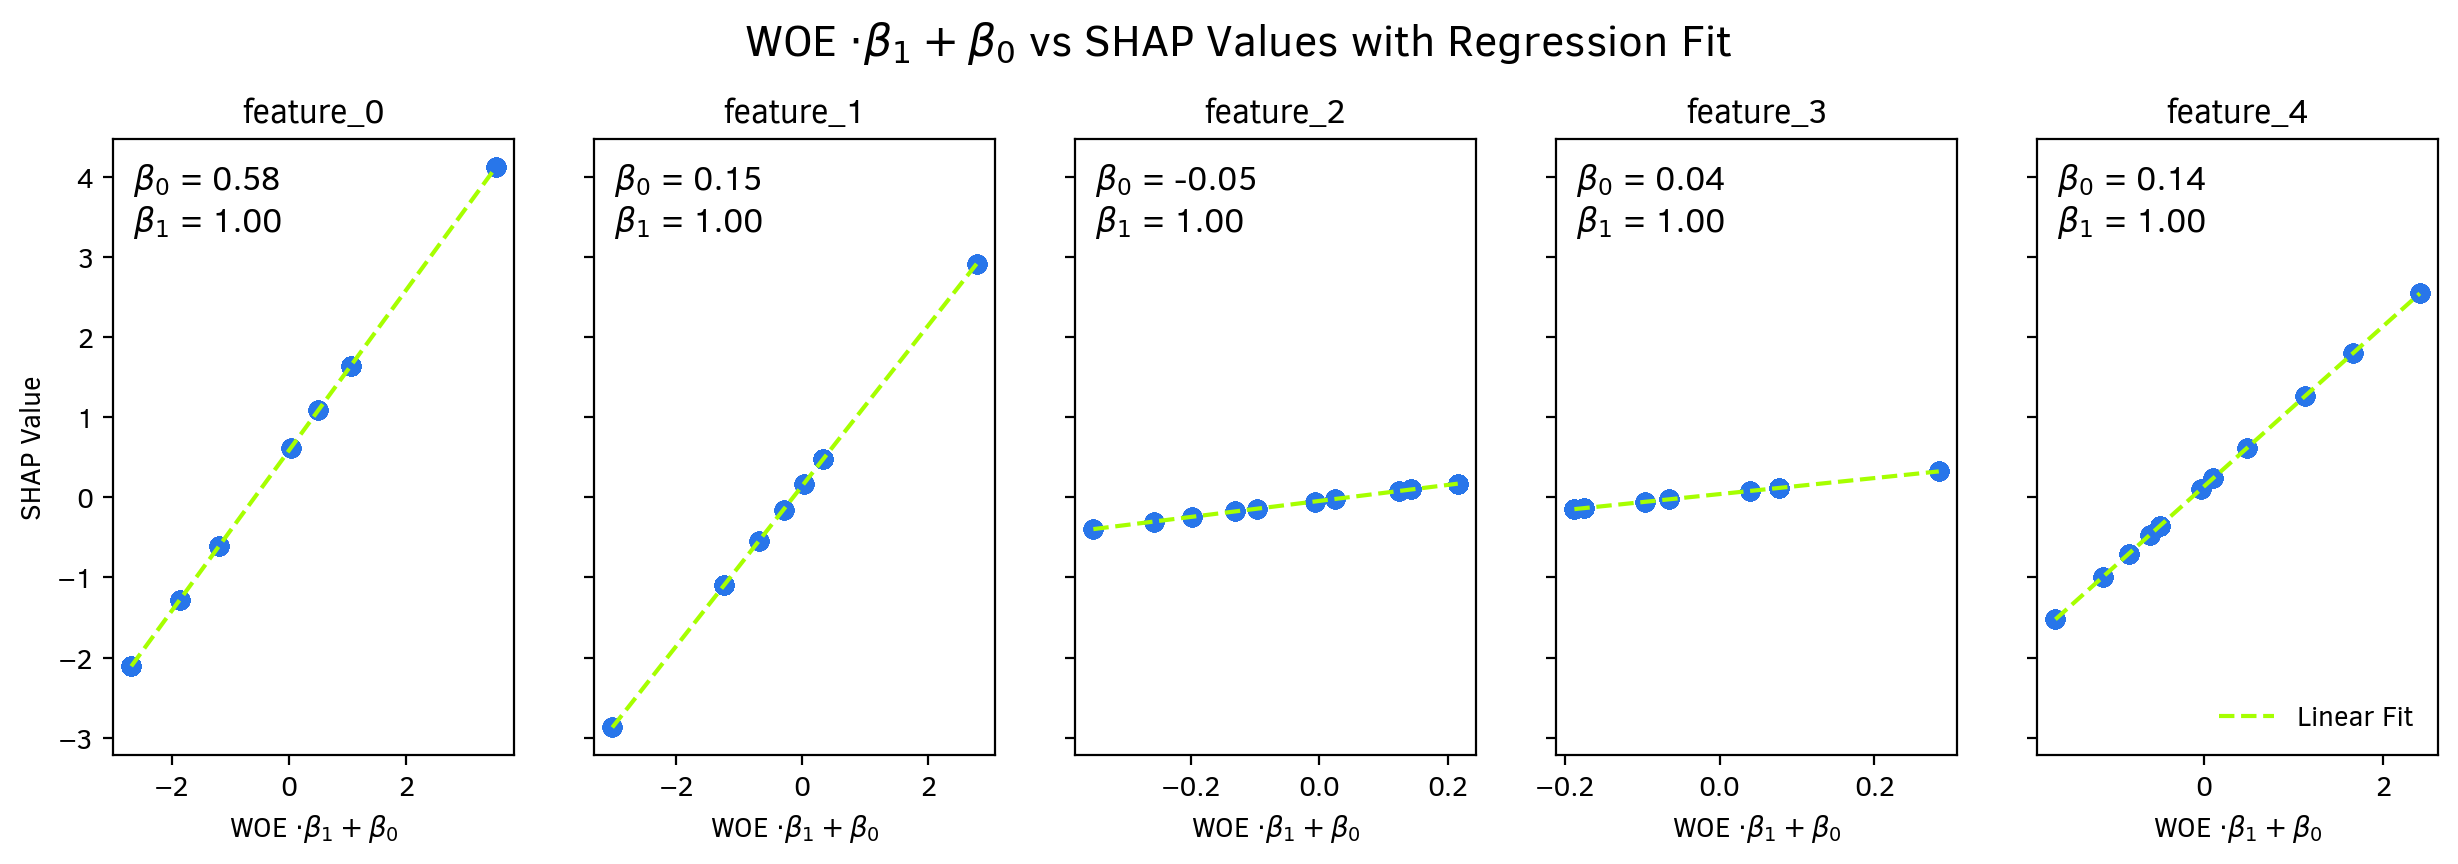

In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Extracting necessary values
features = X.columns

# Fit linear regression models to predict SHAP values from WOE-scaled features
lrs = []
intercepts = []
woe_scaled_corrected = {}

for i, feature in enumerate(features):
    woe_scaled_feature = X_binned[feature].values.reshape(-1, 1) * model.coef_[0][i]
    
    lr = LinearRegression()
    lr.fit(woe_scaled_feature, shap_df[feature].values)  # Fit a simple regression model
    
    lrs.append(lr)
    intercepts.append(lr.intercept_)
    woe_scaled_corrected[feature] = woe_scaled_feature.flatten()  # Store corrected WOE values

# Scatter plot for each feature: WOE * β_i vs SHAP values with regression intercepts
fig, axes = plt.subplots(1, len(features), figsize=(15, 4), sharey=True)

for i, feature in enumerate(features):
    axes[i].scatter(woe_scaled_corrected[feature], shap_df[feature].values, alpha=0.5, color='#2876EA')
    
    # Regression line
    x_range = np.linspace(
        min(woe_scaled_corrected[feature]), max(woe_scaled_corrected[feature]), 100
    ).reshape(-1, 1)
    y_pred = lrs[i].predict(x_range)
    axes[i].plot(x_range, y_pred, color="#A6FF00", linestyle="dashed", label="Linear Fit")

    axes[i].set_title(feature)
    axes[i].set_xlabel(r"WOE $\cdot \beta_1 + \beta_0$")

    if i == 0:
        axes[i].set_ylabel("SHAP Value")

    # Add intercept value as label
    axes[i].text(
        0.05,
        0.85,
        rf"$\beta_0$ = {intercepts[i]:.2f}"
        + "\n" + rf"$\beta_1$ = {lrs[i].coef_[0]:.2f}",
        transform=axes[i].transAxes,
        fontsize=12
    )

plt.suptitle(r"WOE $\cdot \beta_1 + \beta_0$ vs SHAP Values with Regression Fit", fontsize=16, y=1.03)
plt.legend(loc="lower right", frameon=False)
plt.savefig("woe_lr_vs_shap.png", transparent=True, dpi=300, bbox_inches="tight")
plt.show()

# **Note**: Compared to pure WOE, we can notice that intercept values changed in the chart above.
# The reason is that here the WOE values are scaled by logistic regression coefficients fit on top.

In [13]:
from IPython.display import Markdown

display(Markdown(r"$WOE_i \cdot \beta_i$"))
display(X_binned.head(1) * model.coef_)

display(Markdown(r"$WOE_i \cdot \beta_i = SHAP_i - E[WOE_i]$"))
display(shap_df.head(1).iloc[:, :5] - intercepts[0])

display(Markdown(r"$SHAP_i = WOE_i \cdot \beta_i + E[WOE_i]$"))
display(X_binned.head(1) * model.coef_ + intercepts[0])

$WOE_i \cdot \beta_i$

,feature_0,feature_1,feature_2,feature_3,feature_4
0,1.055388,0.018852,-0.096668,0.0765,0.09759


$WOE_i \cdot \beta_i = SHAP_i - E[WOE_i]$

,feature_0,feature_1,feature_2,feature_3,feature_4
0,1.055388,-0.419741,-0.726764,-0.468004,-0.34942


$SHAP_i = WOE_i \cdot \beta_i + E[WOE_i]$

,feature_0,feature_1,feature_2,feature_3,feature_4
0,1.640311,0.603775,0.488254,0.661423,0.682512


## Joint visualization

Here we aim to visualize the effect of fitting Logistic Regression over WOE-transformed inputs.

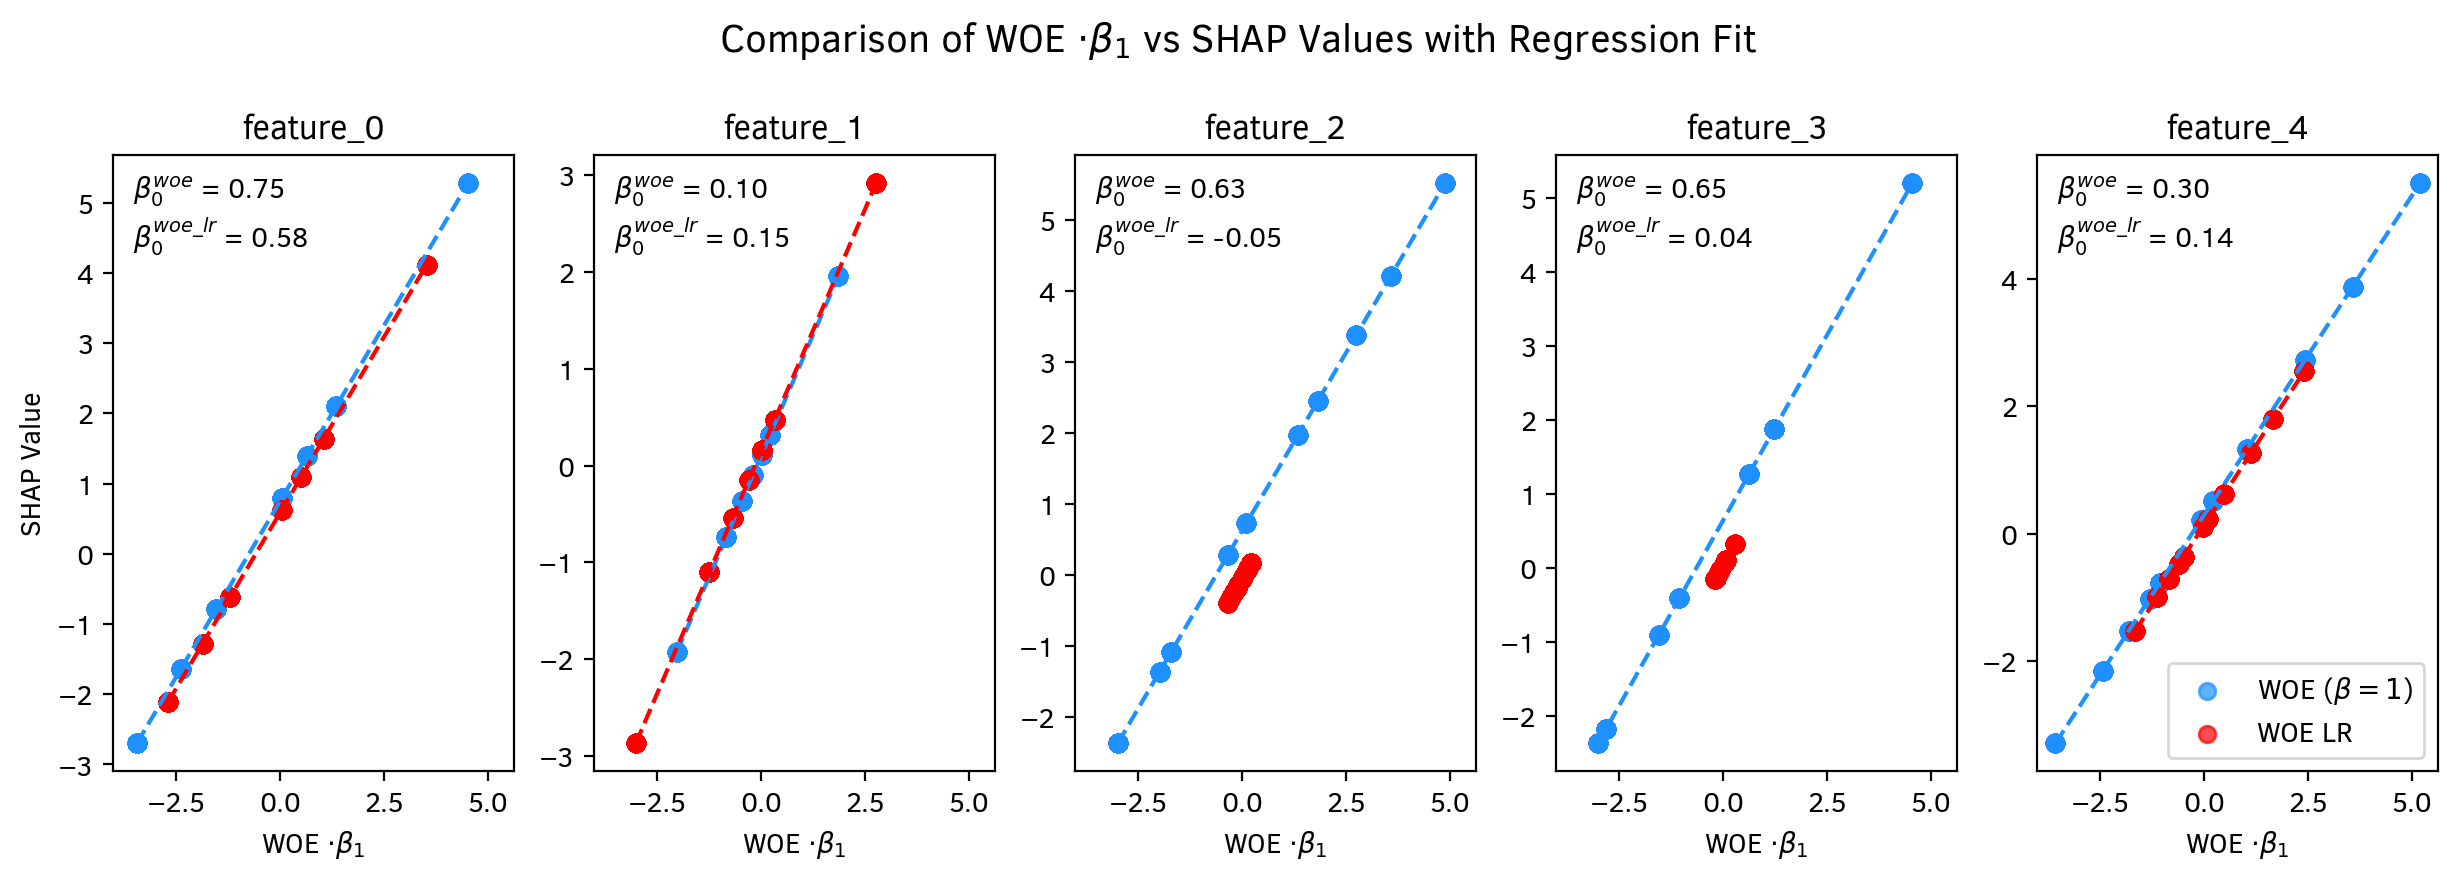

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Fake Logistic Regression model (WOE)
explainer_woe = shap.LinearExplainer(
    fake_logistic,
    masker=maskers.Independent(X_woe, max_samples=len(X_woe)),
)
shap_values_woe = explainer_woe.shap_values(X_woe)
shap_df_woe = pd.DataFrame(shap_values_woe, columns=X.columns)

# WOE Logistic Regression model
explainer_woe_lr = shap.LinearExplainer(
    model,
    masker=maskers.Independent(X_binned, max_samples=len(X_binned)),
)
shap_values_woe_lr = explainer_woe_lr.shap_values(X_binned)
shap_df_woe_lr = pd.DataFrame(
    shap_values_woe_lr, columns=X.columns
)

# Extracting necessary values
features = X.columns

# Fit linear regression models for both WOE and WOE * β_i
lrs_woe, lrs_woe_lr = [], []
intercepts_woe, intercepts_woe_lr = [], []
woe_scaled_corrected, woe_lr_scaled_corrected = {}, {}

for i, feature in enumerate(features):
    # Compute WOE-based feature transformations
    woe_feature = X_woe[feature].values.reshape(-1, 1) * fake_logistic.coef_[0][i]
    woe_lr_feature = X_binned[feature].values.reshape(-1, 1) * model.coef_[0][i]

    # Fit regression models
    lr_woe = LinearRegression()
    lr_woe.fit(woe_feature, shap_df_woe[feature].values)

    lr_woe_lr = LinearRegression()
    lr_woe_lr.fit(woe_lr_feature, shap_df_woe_lr[feature].values)

    # Store models and values
    lrs_woe.append(lr_woe)
    lrs_woe_lr.append(lr_woe_lr)

    intercepts_woe.append(lr_woe.intercept_)
    intercepts_woe_lr.append(lr_woe_lr.intercept_)

    woe_scaled_corrected[feature] = woe_feature.flatten()
    woe_lr_scaled_corrected[feature] = woe_lr_feature.flatten()

# Scatter plot for each feature: Comparing WOE vs WOE * β_i
fig, axes = plt.subplots(1, len(features), figsize=(15, 4), sharey=False, sharex=True)

for i, feature in enumerate(features):
    axes[i].scatter(
        woe_scaled_corrected[feature],
        shap_df_woe[feature].values,
        alpha=0.7,
        label=r"WOE ($\beta = 1$)",
        color="dodgerblue",
    )
    axes[i].scatter(
        woe_lr_scaled_corrected[feature],
        shap_df_woe_lr[feature].values,
        alpha=0.7,
        label="WOE LR",
        color="red",
    )

    # Regression line for WOE
    x_range_woe = np.linspace(
        min(woe_scaled_corrected[feature]), max(woe_scaled_corrected[feature]), 100
    ).reshape(-1, 1)
    y_pred_woe = lrs_woe[i].predict(x_range_woe)
    axes[i].plot(x_range_woe, y_pred_woe, color="dodgerblue", linestyle="dashed")

    # Regression line for WOE * β_i
    x_range_woe_lr = np.linspace(
        min(woe_lr_scaled_corrected[feature]),
        max(woe_lr_scaled_corrected[feature]),
        100,
    ).reshape(-1, 1)
    y_pred_woe_lr = lrs_woe_lr[i].predict(x_range_woe_lr)
    axes[i].plot(x_range_woe_lr, y_pred_woe_lr, color="red", linestyle="dashed")

    axes[i].set_title(feature)
    axes[i].set_xlabel(r"WOE $\cdot \beta_1$")

    if i == 0:
        axes[i].set_ylabel("SHAP Value")

    # Add intercept value as label
    axes[i].text(
        0.05,
        0.85,
        rf"$\beta_0^{{woe}}$ = {intercepts_woe[i]:.2f}"
        + "\n"
        + rf"$\beta_0^{{woe\_lr}}$ = {intercepts_woe_lr[i]:.2f}",
        # + "\n"
        # + rf"$\beta_1^{{\Delta}}$ = {1 /(intercepts_woe[i] / intercepts_woe_lr[i]):.2f}",
        transform=axes[i].transAxes,
        fontsize=10,
    )

plt.suptitle(
    r"Comparison of WOE $\cdot \beta_1$ vs SHAP Values with Regression Fit",
    fontsize=14,
    y=1.05,
)
plt.legend(loc="best")
plt.show()

## SHAP scorecard

* **Example 1**: SHAP scorecard for a linear model,
* **Example 2**: SHAP scorecard for a tree-based model.

For tree-based models, we manually calculate and add base score (intercept).

In [15]:
import pandas as pd
import numpy as np
import shap
from scipy.special import logit

def compute_shap_scores(
    model=None,
    X=None,
    y=None,
    shap_df=None,
    scorecard_dict=None,
    base_score=None,
    model_type="tree",
    masker=True  # Toggle whether SHAP uses a masker
):
    """
    Convert SHAP values into a scorecard-like system for both linear and tree-based models.

    Parameters:
    - model: Trained ML model (Logistic Regression, CatBoost, XGBoost, LightGBM).
    - X (pd.DataFrame): Input dataset.
    - y (pd.Series or np.array): Target variable (only required for tree models).
    - shap_df (pd.DataFrame): Precomputed SHAP values (only required for linear models).
    - scorecard_dict (dict): Config for score scaling (PDO, target points, target odds).
    - base_score (float): Base log-odds score for tree-based models. If None, estimated from dataset.
    - model_type (str): "tree" for gradient boosting models, "linear" for logistic regression.
    - masker (bool): Whether to use a SHAP masker to ensure consistency.

    Returns:
    - pd.DataFrame: Scorecard with feature-wise contributions and final score.
    """

    if scorecard_dict is None:
        scorecard_dict = {
            "pdo": 20,
            "target_points": 500,
            "target_odds": 19,
        }

    pdo = scorecard_dict["pdo"]
    target_points = scorecard_dict["target_points"]
    target_odds = scorecard_dict["target_odds"]

    # Compute scaling factor and offset
    factor = pdo / np.log(2)
    offset = target_points + factor * np.log(target_odds)

    if model_type == "tree":
        # Ensure required inputs
        if model is None or X is None or y is None:
            raise ValueError("For tree models, 'model', 'X', and 'y' must be provided.")

        # Compute base score if not provided
        if base_score is None:
            base_score = logit(np.mean(y))  # Estimate from dataset

        # Create SHAP explainer
        explainer = shap.TreeExplainer(
            model,
            masker=shap.maskers.Independent(X, max_samples=len(X)) if masker else X,
        )
        shap_values = explainer.shap_values(X)

        # Handle multi-class case (CatBoost, XGBoost)
        if isinstance(shap_values, list):  
            shap_values = shap_values[1]  # Pick positive class for binary classification

        # Convert to DataFrame
        shap_df = pd.DataFrame(shap_values, columns=X.columns)
        intercept_ = base_score  # Use estimated base log-odds

    elif model_type == "linear":
        # Ensure required inputs are available
        if model is None or X is None:
            raise ValueError("For linear models, 'model' and 'X' must be provided.")

        # Create SHAP explainer
        explainer = shap.LinearExplainer(
            model,
            masker=shap.maskers.Independent(X, max_samples=len(X)) if masker else X,
        )

        # Compute SHAP values
        shap_values = explainer.shap_values(X)
        shap_df = pd.DataFrame(shap_values, columns=X.columns)

        # Use model intercept (average log-odds)
        intercept_ = float(model.intercept_) if hasattr(model, "intercept_") else 0

    else:
        raise ValueError("Invalid model type. Choose 'tree' or 'linear'.")

    # Compute feature-level scores
    scorecard_df = pd.DataFrame()
    for feature in X.columns:
        scorecard_df[f"{feature}_score"] = factor * -shap_df[feature] + intercept_

    # Compute final score by summing feature-level scores
    scorecard_df["score"] = scorecard_df.sum(axis=1) + offset

    return scorecard_df.round(0)

In [16]:
import catboost as cb

# Compute Scorecard
log_shap_scorecard = compute_shap_scores(
    model=model,
    X=X_binned,
    scorecard_dict={'pdo': 10, 'target_points': 500, 'target_odds': 19},
    model_type="linear",
    masker=True
)

display(log_shap_scorecard.head(5))

# Train CatBoost model
model_gbdt = cb.CatBoostClassifier(
    iterations=500,
    depth=4,
    learning_rate=0.1,
    verbose=0,
    allow_writing_files=False
)
model_gbdt.fit(X, y)

# Compute SHAP-based scorecard
tree_shap_scorecard = compute_shap_scores(
    model=model_gbdt,
    X=X,
    y=y,
    scorecard_dict={'pdo': 10, 'target_points': 500, 'target_odds': 19},
    model_type="tree",
    masker=False
)

display(tree_shap_scorecard.head(5))

,feature_0_score,feature_1_score,feature_2_score,feature_3_score,feature_4_score,score
0,-24.0,-3.0,2.0,-2.0,-4.0,511.0
1,30.0,-7.0,-0.0,2.0,-9.0,557.0
2,-60.0,15.0,5.0,-5.0,-26.0,471.0
3,8.0,7.0,-2.0,-0.0,10.0,566.0
4,-24.0,-7.0,3.0,-2.0,-26.0,485.0


,feature_0_score,feature_1_score,feature_2_score,feature_3_score,feature_4_score,score
0,-15.0,24.0,-18.0,2.0,6.0,542.0
1,40.0,-10.0,14.0,12.0,5.0,604.0
2,-41.0,-22.0,-23.0,-38.0,-18.0,400.0
3,-3.0,11.0,6.0,-4.0,10.0,563.0
4,-32.0,-35.0,-55.0,-15.0,-18.0,388.0


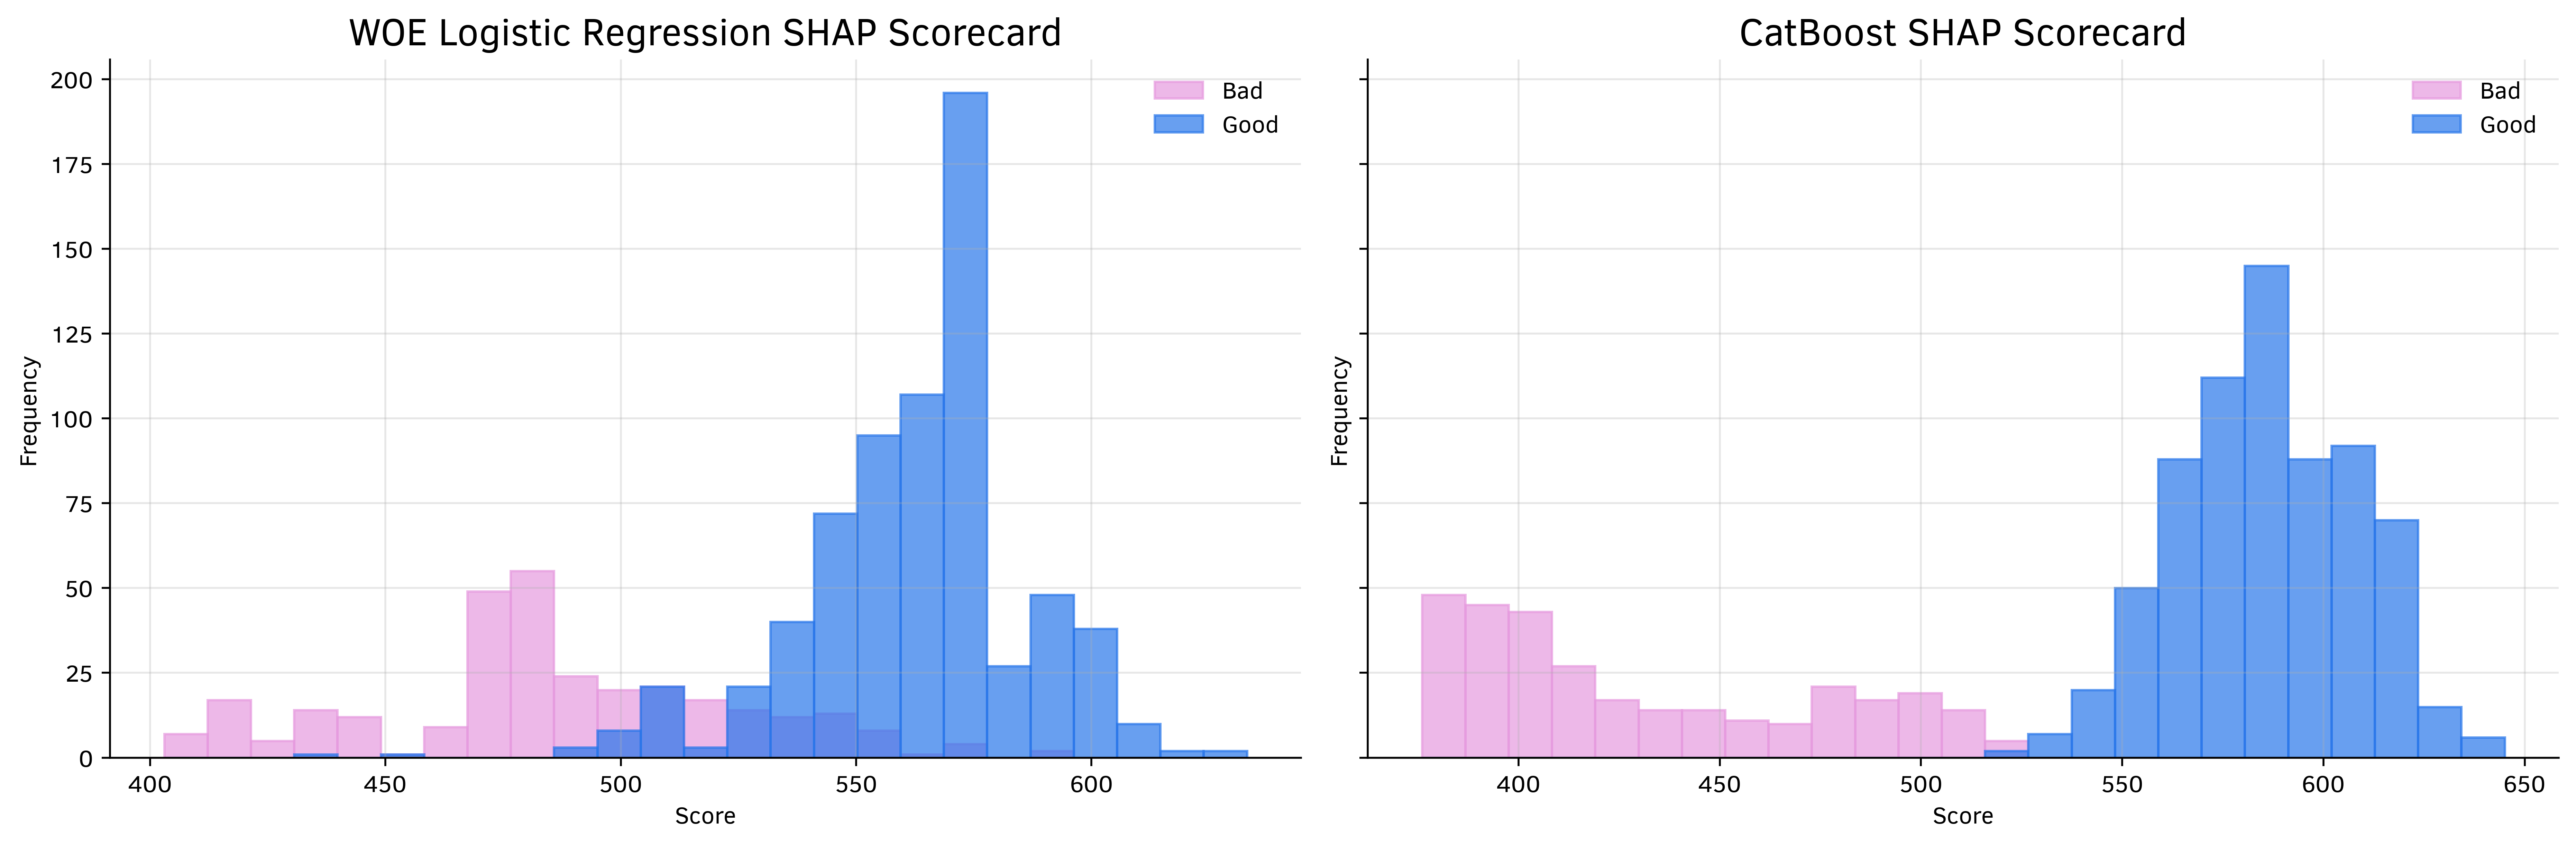

In [17]:
import matplotlib.pyplot as plt
import numpy as np


def plot_shap_scorecards(scorecards, y, num_bins=25):
    """
    Plot SHAP-based score distributions for multiple models side by side.

    Parameters:
    - scorecards: List of tuples [(scorecard_df, model_name)]
    - titles: List of plot titles.
    - y: Target variable indicating class labels (0/1).
    - num_bins: Number of bins for histograms.
    """
    _, axes = plt.subplots(1, len(scorecards), figsize=(15, 5), sharey=True, dpi=250)

    for ax, (scorecard, title) in zip(axes, scorecards):
        # Compute bin edges based on score range
        bins = np.linspace(
            scorecard["score"].min(), scorecard["score"].max(), num_bins + 1
        )

        # Plot histograms for "Bad" and "Good" classes
        ax.hist(
            scorecard.loc[y == 1, "score"],
            bins=bins,
            label="Bad",
            color="#E69ADF",
            edgecolor="#E69ADF",
            alpha=0.7,
        )
        ax.hist(
            scorecard.loc[y == 0, "score"],
            bins=bins,
            label="Good",
            color="#2876EA",
            edgecolor="#2876EA",
            alpha=0.7,
        )

        # Set labels and formatting
        ax.set_xlabel("Score")
        ax.set_ylabel("Frequency")
        ax.set_title(title, fontsize=16)
        ax.legend(frameon=False)
        ax.grid(alpha=0.3)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.savefig("shap_scorecards.png", transparent=True, dpi=300, bbox_inches="tight")
    plt.show()


# Call function to plot both scorecards
plot_shap_scorecards(
    scorecards=[
        (log_shap_scorecard, "WOE Logistic Regression SHAP Scorecard"),
        (tree_shap_scorecard, "CatBoost SHAP Scorecard"),
    ],
    y=y,
)

## Performance under covariate shift

Below we examine the performance of the models under covariate shift.

Intercept: 556.33 | Coef: [-20.84820168  -4.88057898 -27.32864311 -14.58934134  12.91776901]


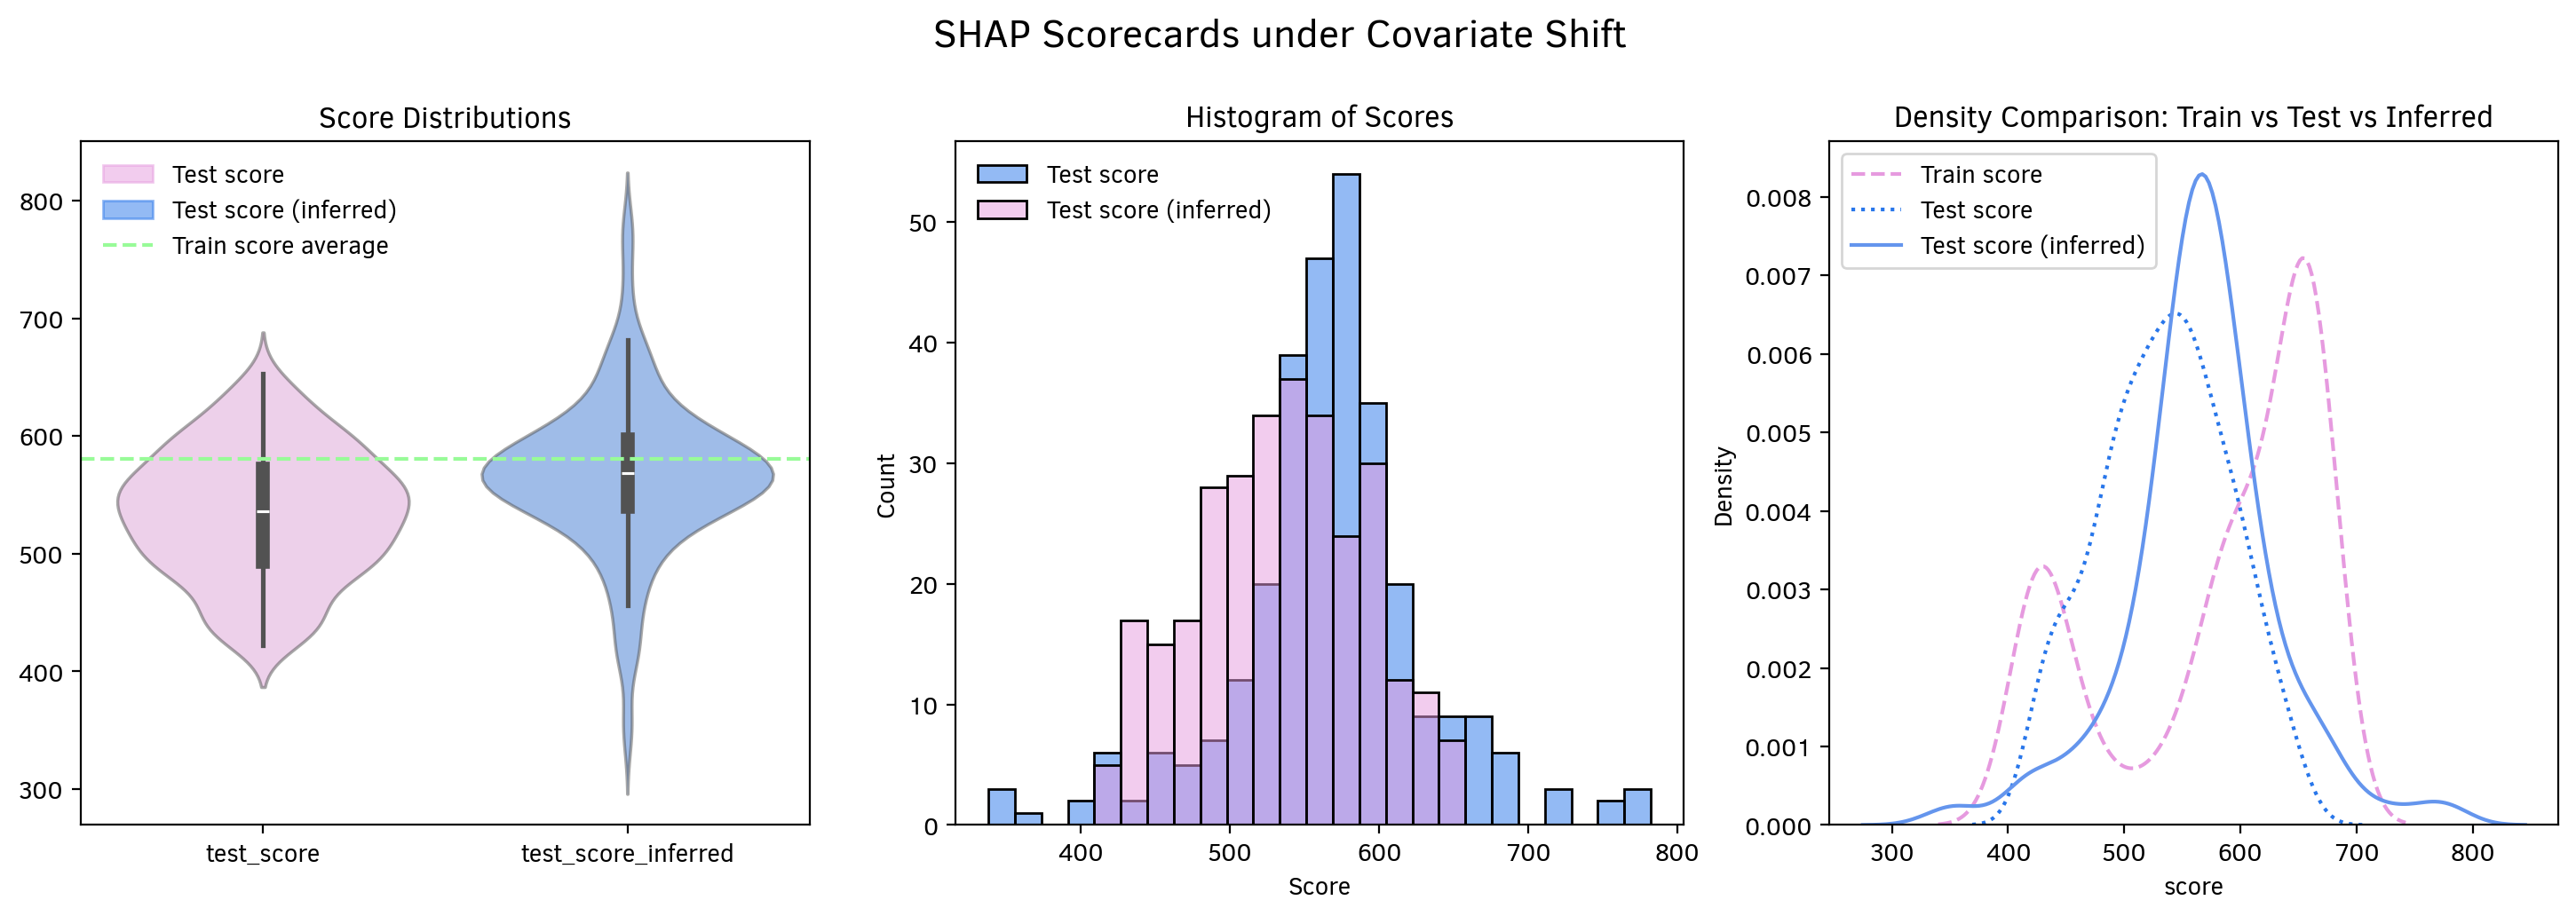

In [18]:
import pandas as pd
import numpy as np
import catboost as cb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

np.random.seed(42)

# Define custom colors
custom_palette = ["#E69ADF", "#2876EA", "#6495ED"]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_train, X_test = [
    pd.DataFrame(df, columns=[f"feature_{i}" for i in range(X.shape[1])])
    for df in (X_train, X_test)
]

# Introduce Covariate Shift
X_test_shifted = X_test.copy()

# Add random noise to features
for i in range(5):
    X_test_shifted[f"feature_{i}"] *= np.random.normal(0.5, 1, X_test_shifted.shape[0])

# Train Model
tree_model = cb.CatBoostClassifier(
    iterations=100, depth=4, learning_rate=0.1, verbose=0
)
tree_model.fit(X_train, y_train)

# Compute SHAP Scorecard Values
tree_shap_scorecard_train = compute_shap_scores(
    model=tree_model,
    X=X_train,
    y=y_train,
    model_type="tree",
)

# Fit Calibrator using raw inputs
calibrator_tree = LinearRegression()
calibrator_tree.fit(X_train, tree_shap_scorecard_train["score"].round(0))

print(f"Intercept: {calibrator_tree.intercept_:.2f} | Coef: {calibrator_tree.coef_}")

# Predict SHAP scorecard score using calibrator
tree_scorecard_test_clb = calibrator_tree.predict(X_test_shifted).round(0)

# Compute SHAP Scorecard Values for Shifted Data
tree_shap_scorecard_shifted = compute_shap_scores(
    model=tree_model,
    X=X_test_shifted,
    y=y_test,
    model_type="tree",
)

# Store Results
score_data = pd.DataFrame(
    {
        "test_score": tree_shap_scorecard_shifted["score"],
        "test_score_inferred": tree_scorecard_test_clb.round(0)
    }
)

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Violin Plot (Score Distributions)
sns.violinplot(data=score_data, ax=axes[0], palette=custom_palette, alpha=0.5)
axes[0].set_title("Score Distributions")
axes[0].axhline(
    tree_shap_scorecard_train["score"].mean(),
    color="palegreen",
    linestyle="--"
)

# Manually create legend handles
legend_patches = [
    mpatches.Patch(color=custom_palette[0], label="Test score", alpha=0.5),
    mpatches.Patch(color=custom_palette[1], label="Test score (inferred)", alpha=0.5),
    mlines.Line2D([], [], color="palegreen", linestyle="--", label="Train score average")
]

axes[0].legend(handles=legend_patches, frameon=False)

# Histogram (Raw Score Distributions)
sns.histplot(
    score_data,
    ax=axes[1],
    kde=False,
    bins='auto',
    palette=custom_palette,
    alpha=0.5
)
axes[1].set_title("Histogram of Scores")
axes[1].set_xlabel("Score")
axes[1].legend(["Test score", "Test score (inferred)"], frameon=False)

# KDE Plot
sns.kdeplot(
    tree_shap_scorecard_train["score"], label="Train score", color=custom_palette[0], linestyle="--"
)
sns.kdeplot(
    tree_shap_scorecard_shifted["score"], label="Test score", color=custom_palette[1], linestyle=":"
)
sns.kdeplot(
    score_data["test_score_inferred"], label="Test score (inferred)", color=custom_palette[2]
)
axes[2].set_title("Density Comparison: Train vs Test vs Inferred")
axes[2].legend()

plt.suptitle("SHAP Scorecards under Covariate Shift", fontsize=16, y=1.02)
plt.savefig("shap_scorecard_shift.png", transparent=True, dpi=300, bbox_inches="tight")
plt.show()